<a href="https://colab.research.google.com/github/hereagain-Y/TCR_VAE/blob/main/Brian_lungtrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Latent space frist then pairs

Test latent distance calculation on GPU

In [1]:
import itertools
import pandas as pd 
import random
import time
from datetime import datetime
from pkgutil import extend_path
import numpy as np
import matplotlib.pyplot as plt

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
#
from scipy.spatial import distance
import random 
from scipy import spatial
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

torch.cuda.empty_cache()

In [4]:
AAs= ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
index_code = {}
code_index = {}
l_max = 20
for i in range(len(AAs)):
    index_code[i] = AAs[i]
    code_index[ AAs[i] ] = i

def oneHotEncode(seq, l_max=l_max, index_code=index_code, code_index=code_index):
    n_amino = 20
    matrix = np.zeros((l_max,n_amino)).astype(int)
    for i in range(len(seq)):
        matrix[ i , code_index[seq[i]] ] = 1
    return matrix

# pca encoded 
pca_index = pd.read_csv("/content/drive/My Drive/DL/VAE/AA_indexPCA.csv")
d=pca_index.set_index('Unnamed: 0').T.to_dict('list')


# pca normalization
data = d.items()
list_dat = list(d.values())
arr = np.array(list_dat)
ex = np.array(arr)
ex_norm = (ex-ex.min(axis=0))/(ex.max(axis=0)-ex.min(axis=0))

AAs=np.array(list(d.keys()))
new_pca = {}

for i in np.arange(20):
    new_pca[AAs[i]]=ex_norm[i]

new_pca
d= new_pca

def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global l_max
    AAE=np.zeros([l_max,20])
    if length_seq<l_max:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d[AA] # add PC value 
            
        for amino in range(length_seq,l_max):
            AAE[amino,]=np.zeros(20)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 

  
def GetFeatures(file):
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode,dtype=np.float32)
    result=np.array(hot_encode,dtype=np.float32)
    return(result)

In [ ]:
start_time=datetime.now()

In [64]:
cuda = True
channels =1
device = torch.device("cuda" if cuda else "cpu")


In [6]:

class VAE(nn.Module):
    def __init__(self,h_dim=64*10*10, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=5, stride=1), #16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1), # 12
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), #10
            nn.ReLU()
        
        )

        
        
        # mean 64*5*5 =
        self.fc1 = nn.Linear(h_dim, z_dim)
        # var 
        self.fc2 = nn.Linear(h_dim, z_dim)
        # for decoder layer 
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            
   
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu):
        #std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        #esp = torch.randn(*mu.size())
        z = mu
        return z
    
    def bottleneck(self, h):
        mu= self.fc1(h)
        z = self.reparameterize(mu)
        return mu, z
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0] # latent layer 

        
    
    #def alignmentscore(self,x,y):
    #    scores = pairwise2.align.localds(x,y,align_matrix,open=open_penalty,extend=gap_penalty)
    #    score_align = scores[0].score
    #    return score_align
        
    def latent(self,x,y):
        l1 = self.encoder(x)# 32
        l1 = l1.view(-1,64*10*10) # 32
        l1, mu1 = self.bottleneck(l1)

        l2 = self.encoder(y)# 32
        l2 = l2.view(-1,64*10*10) # 32
        l2, mu2 = self.bottleneck(l2)
        # use cos-simialrity
        #latent_dist =np.sqrt( np.sum(np.square(l1 - l2)) )
        
        
        return l1,l2

    def forward(self, x,y):
      # for dataset 1
        h1= self.encoder(x)
        h1 = h1.view(-1,64*10*10)
        z1, mu1 = self.bottleneck(h1) #
        z1 = self.fc3(z1) # 64*10*10
        z1 = z1.view(-1,64,10,10)
        z1 = self.decoder(z1)
      # for dat2   
        h2= self.encoder(y)
        h2 = h2.view(-1,64*10*10)
        z2, mu2 = self.bottleneck(h2)
        z2 = self.fc3(z2)
        z2 = z2.view(-1,64,10,10)
        z2 = self.decoder(z2)
        
        # aligment 
        #s = self.alignmentscore(x,y)
        # latent distance
        l1,l2 = self.latent(x,y)
        
        
        
        return z1, mu1,z2,mu2,l1,l2

In [7]:
model=torch.load('/content/drive/MyDrive/DL/CNNVAE/Paired_sigmoid_modified_1000_echo_cat_train.apx')

In [8]:
# move model to gpu
if torch.cuda.is_available():
    model.cuda()

Read Brain&Lung Data

In [10]:
seq_test = pd.read_csv('/content/drive/My Drive/DL/Lung_data/1_Brain_Met.txt',delimiter='\t',header=None,names=['seq','count'])
seq_test['length'] = [len(seq) for seq in seq_test['seq']]

seq_test = seq_test[ seq_test['length']<=20 ]


In [9]:
import os
import glob

In [72]:
# read data into csv 
data_files = r"/content/drive/My Drive/DL/Lung_data/"
df_mango= pd.DataFrame()
all_files = glob.glob(os.path.join(data_files , "*Brain_Met.txt"))
brain =[]
counts=[]
for filename in all_files:
    df = pd.read_csv(filename,delimiter='\t',header=None,names=['seq','count'])
    df=df.iloc[1:,:]
    df['length'] = [len(seq) for seq in df['seq']]
    df= df[ df['length']<=20 ]
    count=len(df['seq'])
    brain.append(df)
    counts.append(count)
brain_data= pd.concat(brain, axis=0, ignore_index=True)


In [73]:
lung_file =glob.glob(os.path.join(data_files , "*Lung.txt"))
lung=[]
counts2=[]
for filename in lung_file:
    df = pd.read_csv(filename,delimiter='\t',header=None,names=['seq','count'])
    df=df.iloc[1:,:]
    df['length'] = [len(seq) for seq in df['seq']]
    df= df[ df['length']<=20 ]
    count=len(df['seq'])
    lung.append(df)
    counts2.append(count)
lung_data= pd.concat(lung, axis=0, ignore_index=True)
#lung_data=pd.concat((pd.read_csv(f,delimiter='\t',header=None,names=['seq']) for f in lung_file ),axis=0,ignore_index=False)

In [12]:
brain_data[:5]

,seq,count,length
0,CAAGAGLSTDTQYF,1,14
1,CAGERAYEQYF,1,11
2,CAGKPSGSGANVLTF,1,15
3,CAIGTGGLSEAFF,1,13
4,CAILAGGQETQYF,1,13


In [ ]:
def check_count(data,count):
  if (len(data)%2==0):
    count=count
    print(len(data))
  else:
    print('this is odd')
    count[(len(lung_file)-1)]=  count[(len(lung_file)-1)]-1
  return count

In [75]:
counts=check_count(brain_data,counts)
counts2=check_count(lung_data,counts2)

this is odd
this is odd


In [76]:
def check_data(data):
  if (len(data)%2==0):
    data= data
    print(len(data))
  else:
    print('this is odd')
    data=data[:-1]
  return data




In [69]:
counts

[865, 1703, 520, 6260, 1256, 469, 804, 1877, 961]

In [42]:
counts2

[4124, 5432, 6069, 1011, 6375, 8090, 2041, 1269, 4446]

In [44]:
ex=counts+counts2

In [50]:
counts

this is odd


[865, 1703, 520, 6260, 1256, 469, 804, 1877]

In [14]:
lung_data=check_data(lung_data)
brain_data = check_data(brain_data)

this is odd
this is odd


In [15]:
len(lung_data)

38856

In [16]:
seq_brain=list(brain_data['seq'])

In [17]:
seq_lung=list(lung_data['seq'])

In [18]:
AA_b1=GetFeatures(seq_brain[:int(len(brain_data)/2)]) # 5000
AA_b2=GetFeatures(seq_brain[int(len(brain_data)/2):len(brain_data)]) #5000

AA_l1=GetFeatures(seq_lung[:int(len(lung_data)/2)]) # 5000
AA_l2=GetFeatures(seq_lung[int(len(lung_data)/2):len(lung_data)]) #5000

train_loaderx= DataLoader(torch.from_numpy(AA_b1).float(), batch_size=1000, shuffle=False)
train_loadery = DataLoader(torch.from_numpy(AA_b2).float(),batch_size=1000,shuffle=False)

lung_loaderx= DataLoader(torch.from_numpy(AA_l1).float(), batch_size=1000, shuffle=False)
lung_loadery = DataLoader(torch.from_numpy(AA_l2).float(),batch_size=1000,shuffle=False)

In [19]:
latent1=[]
latent2=[]
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(zip(train_loaderx, train_loadery)):
        x=x.view(len(x),1,20,20).to(device)
        y=y.view(len(y),1,20,20).to(device)
        x_hat, mean_x,y_hat,mean_y,l1,l2= model(x,y)
        #dis = torch.nn.functional.pairwise_distance(l1, l2,2)
        latent1.append(l1)
        latent2.append(l2)

In [20]:
stacked_l1 = torch.cat(latent1)
stacked_l2 = torch.cat(latent2)


In [21]:
stack_l1 =stacked_l1.cpu().detach().numpy()
stack_l2=stacked_l2.cpu().detach().numpy()

In [22]:
latent_brain=np.concatenate((stack_l1,stack_l2), axis=0)


In [23]:
latent_brain.shape

(14714, 32)

In [24]:
latent3=[]
latent4=[]
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(zip(lung_loaderx, lung_loadery)):
        x=x.view(len(x),1,20,20).to(device)
        y=y.view(len(y),1,20,20).to(device)
        x_hat, mean_x,y_hat,mean_y,l1,l2= model(x,y)
        #dis = torch.nn.functional.pairwise_distance(l1, l2,2)
        latent3.append(l1)
        latent4.append(l2)
stacked_l3 = torch.cat(latent3)
stacked_l4 = torch.cat(latent4)
stack_l3 =stacked_l3.cpu().detach().numpy()
stack_l4=stacked_l4.cpu().detach().numpy()
latent_lung=np.concatenate((stack_l3,stack_l4), axis=0)

In [25]:
total_seq= np.concatenate((latent_brain,latent_lung),axis=0)

In [26]:
sequences = torch.from_numpy( np.array(total_seq)).float()

In [27]:
sequences.shape # check dim is ok

torch.Size([53570, 32])

In [28]:
sequences[0]

tensor([ 21.8486, -13.9713,  -4.2095,  18.5930,  -5.4254,  -1.2194,  19.9250,
          8.1279, -31.9806,  17.0616,  12.3843,  14.4362,  -5.9183, -10.7043,
         -8.4698,   9.8114,  -5.7981,  16.0426,  -4.5814,   1.3349,  -1.2115,
         -6.7483,   8.3194,  22.3002, -17.1692,  -4.8241,  14.4490, -12.6214,
          3.7298,  20.6780,  24.0889,   8.8792])

In [ ]:
# combine data together 
# 9 lung 9 brain 

In [ ]:
def getSampleIndex(sample):
    sample_list = list( set(sample) )
    sample_array = np.array(sample)
    sample_index = []
    for s in sample_list:
        sample_index.append( np.where(sample_array==s)[0] )
    return sample_list, sample_index

def gen_multi_list(amount, length):
    seqs = np.random.default_rng()
    return [seqs.random(length) for _ in range(amount)]

sequences = gen_multi_list(1000,16) #50*10
sequences = torch.from_numpy( np.array(sequences)).float()
counts =[]
for i in range(0,1000):
    n=random.randint(1, 5)
    counts.append(n)

counts = torch.from_numpy( np.array( counts ) ).float()
A = ['a','b','c','d','e','f','g','h','i','j']


samples=list(itertools.chain.from_iterable(itertools.repeat(x, 10) for x in A))
label =[]
for i in range(0,10):
    n=random.randint(0, 1)
    label.append(n)
labels = np.repeat(label,10)
  

sample_label_map = { i:j for (i,j) in zip(samples,labels) }
label=torch.from_numpy(np.array( label ).reshape( (len(label),1) )).float()

In [29]:
def getSampleIndex(sample):
    sample_list = list( set(sample) )
    sample_array = np.array(sample)
    sample_index = []
    for s in sample_list:
        sample_index.append( np.where(sample_array==s)[0] )
    return sample_list, sample_index

In [30]:
count1 = list(brain_data['count'].astype(float))
count2 = list(lung_data['count'].astype(float))

In [31]:
count_total = count1+count2

In [32]:
count_total = torch.from_numpy( np.array( count_total ) ).float()

In [82]:
type(count_total)

torch.Tensor

In [34]:
count_total.shape
count_total[:5]

tensor([1., 1., 1., 1., 1.])

In [35]:
A = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']

In [36]:
from itertools import chain, repeat

In [37]:
line_counts = counts+counts2

In [66]:
check_data(counts)

this is odd


[865, 1703, 520, 6260, 1256, 469, 804, 1877]

In [67]:
check_data(counts2)

this is odd


[4124, 5432, 6069, 1011, 6375, 8090, 2041, 1269]

In [48]:
line_counts[8]=counts[8]-1
line_counts[17]=counts2[8]-1

In [68]:
line_counts

[865,
 1703,
 520,
 6260,
 1256,
 469,
 804,
 1877,
 960,
 4124,
 5432,
 6069,
 1011,
 6375,
 8090,
 2041,
 1269,
 4445]

In [49]:
samples=list(chain.from_iterable((repeat(item, cnt) for item, cnt in zip(A,line_counts))))

In [50]:
len(samples)

53570

In [51]:
label=[0,1]
labels=list(itertools.chain.from_iterable(itertools.repeat(x, 9) for x in label))
labels=torch.from_numpy(np.array( labels ).reshape( (len(labels),1) )).float()

In [53]:
labels.shape

torch.Size([18, 1])

In [69]:
#seq_counts=np.concatenate((brain_data['count'].astype(float),lung_data['count'].astype(float)),axis=0)

In [54]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 32 # 512 node fully connected layer
        self.D =  8# 128 node attention layer
        self.K = 1

        # get attention score  make it into 1 dim 
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.K),
            nn.Tanh() # nn,SELU()
           
            
        )
        

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1), # 16,1 
            nn.Sigmoid()
        )
    
    def forward(self,sequence,sample,count):
        A = self.attention(sequence)
        count_col = count.reshape(-1,1)
        A = A*count_col
        newA= torch.clone(A)
        sample_list, sample_index = getSampleIndex(sample)
        sample_feature = []
        for i in range(len(sample_list)):
            seq_numbers = sample_index[i]
            seqs_in_bag = sequence[seq_numbers]
            attention_bag = A[seq_numbers]
            attention_bag = torch.softmax(attention_bag,dim=0)
            seq_feature = seqs_in_bag*attention_bag
            sample_feature.append(seq_feature.sum(dim=0))
            newA[seq_numbers] = attention_bag
        sample_feature =torch.stack(sample_feature,dim=0)
        
        predictions = self.classifier(sample_feature) 
        Y_hat = torch.ge(predictions, 0.5).float() 
        return predictions,Y_hat, sample_list, newA

In [55]:
def loss_function( label, prediction ):
    reproduction_loss = nn.functional.binary_cross_entropy(label, prediction, reduction='sum')
    return reproduction_loss
       
def calculate_classification_error(Y_hat,Y):
    Y = Y.float()
    error = 1. - Y_hat.eq(Y).cpu().float().mean().data

    return error, Y_hat  

In [56]:

from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=1e-3)  
from sklearn.metrics import accuracy_score

In [57]:
Attmodel = Attention()

In [48]:
sample_list, sample_index=getSampleIndex(samples)

In [51]:
seq_numbers=sample_index[5]
seqs_in_bag = sequences[seq_numbers]


Train Set, Epoch: 1, Loss: 191.1932,Error: 0.5000, Accuracy: 50.00%
Train Set, Epoch: 1001, Loss: 191.1932,Error: 0.5000, Accuracy: 50.00%


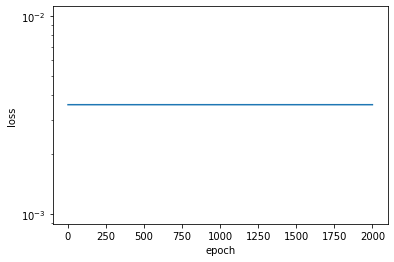

In [63]:
epochs = 2000
def plotCurve(x_vals,y_vals,x_label, y_label,
              x2_vals=None, y2_vals=None, legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
    
    if legend:
        plt.legend(legend) 
train_loss=[]

for ite in range(epochs):
    overall_loss =0
    train_error = 0    
    predictions,Y_hat,sample_list, attention_weights = Attmodel(sequences, samples,count_total )
    #get true sample label, for now, use binary
    #label_true = [ sample_label_map[s] for s in sample_list ]
    #column vectorat
    #label_true = np.array( label_true ).reshape( (len(label_true),1) )
    #label_true = torch.from_numpy( label_true ).float()
    label_true = labels
    #Y_hat.shape 10*1
    #print(label_true[:5])
    #print(Y_hat[:5])
    loss = loss_function(predictions, label_true)
    overall_loss +=loss.item()
    
    error, predicted_label = calculate_classification_error(Y_hat, label_true)
    train_error += error
    
    loss.backward()
    optimizer.step()
    if (ite % 1000 == 0):
      print('Train Set, Epoch: {}, Loss: {:.4f},Error: {:.4f}, Accuracy: {:.2f}%'.format(ite+1, overall_loss,train_error,accuracy_score(label_true, Y_hat)*100))
    train_loss.append(overall_loss/len(sequences))

plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
          ['train'])
      



Test model 

In [61]:
model.eval()
test_loss = 0.
test_error = 0.
with torch.no_grad():
  predictions,Y_hat,sample_list, attention_weights = Attmodel(sequences, samples,count_total )
  label_true = labels
  print('Test set, accuracy :{:.2f}%'.format(accuracy_score(labels,Y_hat)*100))

Test set, accuracy :50.00%


In [77]:
import string

In [84]:
A=list(string.ascii_lowercase)
A= A[:len(lung_file)*2]

In [85]:
samples=list(chain.from_iterable((repeat(item, cnt) for item, cnt in zip(A,line_counts))))

In [86]:
len(samples)

53570

In [87]:
len(sequences)

53570